# 株価予測

In [1]:
# ライブラリインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 設定
pd.options.display.max_columns = 100
pd.options.display.max_rows = 50

%matplotlib inline


In [2]:
# データの読み込み
dir_path = "/Users/Tomoki Yako/tech/competition/SIGNATE/stock-prediction/data/"
train_df = pd.read_csv(dir_path + "train.csv", encoding='utf-8')
test_df = pd.read_csv(dir_path + "test.csv", encoding='utf-8')

In [3]:
train_df.head()

,Date,Open,High,Low,Close,Up
0,2004-01-02,50.85,50.91,50.62,50.72,1
1,2004-01-05,50.75,50.84,50.61,50.79,1
2,2004-01-06,50.87,51.26,50.86,51.15,1
3,2004-01-07,51.45,51.54,51.29,51.51,0
4,2004-01-08,51.15,51.33,51.02,51.28,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2026 non-null   object 
 1   Open    2026 non-null   float64
 2   High    2026 non-null   float64
 3   Low     2026 non-null   float64
 4   Close   2026 non-null   float64
 5   Up      2026 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 95.1+ KB


In [5]:
test_df.head()

,Date,Open,High,Low,Close
0,2012-01-19,110.79,110.82,109.96,110.39
1,2012-01-20,110.45,111.10,110.36,110.73
2,2012-01-23,110.95,111.10,109.65,110.36
3,2012-01-24,110.16,110.16,108.13,108.39
4,2012-01-25,106.25,107.11,105.97,106.89


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1200 non-null   object 
 1   Open    1200 non-null   float64
 2   High    1200 non-null   float64
 3   Low     1200 non-null   float64
 4   Close   1200 non-null   float64
dtypes: float64(4), object(1)
memory usage: 47.0+ KB


In [7]:
# 基礎集計
df = pd.concat([train_df, test_df], ignore_index=None)
df.shape

(3226, 6)

In [8]:
# plt.figure(figsize=(6, 4))
# sns.relplot(data=df, x='Date', y='Close', kind='line')
# plt.show()

In [9]:
# plt.figure(figsize=(6, 4))
# sns.countplot(data=train_df, x='Up')
# plt.show()

In [10]:
# 特徴量エンジニアリング
# 移動平均 Moving Average (MA)
ma_day = [20]#, 50, 200]
for ma in ma_day:
    column_name = f"Close_{ma}MA"
    df[column_name] = df['Close'].rolling(ma, min_periods=1).mean()

In [11]:
# データの分割
train = df[~df['Up'].isnull()]
test = df[df['Up'].isnull()]
test.head()


,Date,Open,High,Low,Close,Up,Close_20MA
0,2012-01-19,110.79,110.82,109.96,110.39,NaN,109.4080
1,2012-01-20,110.45,111.10,110.36,110.73,NaN,109.5215
2,2012-01-23,110.95,111.10,109.65,110.36,NaN,109.5675
3,2012-01-24,110.16,110.16,108.13,108.39,NaN,109.5720
4,2012-01-25,106.25,107.11,105.97,106.89,NaN,109.4415


In [12]:
X_train = train.drop(columns=['Date', 'Up', 'Low', 'High'])
# X_train = train.drop(columns=['Date', 'Up', 'Low', 'High' ])
y_train = train['Up']
print("元のデータフレーム", train.shape)
print("説明変数", X_train.shape)
print("目的変数", y_train.shape)

元のデータフレーム (2026, 7)
説明変数 (2026, 3)
目的変数 (2026,)


In [13]:
# X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=False, random_state=42)
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [14]:
X_tr.head()

,Open,Close,Close_20MA
1052,73.78,73.12,74.3255
1333,74.71,74.77,74.4885
1604,86.41,86.01,86.2160
449,56.62,56.37,56.9070
713,64.29,64.09,63.7195


In [15]:
y_tr.value_counts()

Up
1.0    836
0.0    784
Name: count, dtype: int64

In [16]:
y_va.value_counts()

Up
1.0    209
0.0    197
Name: count, dtype: int64

In [17]:
X_test = test.drop(columns=['Date', 'Up', 'Low', 'High'])
X_test.head()

,Open,Close,Close_20MA
0,110.79,110.39,109.4080
1,110.45,110.73,109.5215
2,110.95,110.36,109.5675
3,110.16,108.39,109.5720
4,106.25,106.89,109.4415


In [18]:
lgb.LGBMClassifier()

params = {
            'task':         'train',
            'boosting_type':'gbdt',
            'objective':    'binary',
            'verbose':      '2',
            'force_col_wise':'True',
            'random_state': '42'
}

In [19]:
train_data = lgb.Dataset(X_tr, label=y_tr)
eval_data = lgb.Dataset(X_va, label=y_va, reference=train_data)

In [20]:
gbm = lgb.train(params,
                train_data,
                valid_sets=eval_data,
                )

[LightGBM] [Info] Number of positive: 836, number of negative: 784
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1620, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516049 -> initscore=0.064220
[LightGBM] [Info] Start training from score 0.064220
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 23
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 22
[LightGBM] [Debug

In [21]:
y_tr_prob_gbm = gbm.predict(X_tr)
y_tr_pred_gbm = np.where(y_tr_prob_gbm < 0.5, 0, 1)
y_va_prob_gbm = gbm.predict(X_va)
y_va_pred_gbm = np.where(y_va_prob_gbm < 0.5, 0, 1)

# y_va_pred_gbm[:5]
accuracy_tr_gbm = accuracy_score(y_tr, y_tr_pred_gbm)
accuracy_va_gbm = accuracy_score(y_va, y_va_pred_gbm)

print("学習データの精度", accuracy_tr_gbm)
print("評価データの精度", accuracy_va_gbm)

# y_test_prob_gbm = gbm.predict(X_test)
# y_test_pred_gbm = np.where(y_test_prob_gbm < 0.5, 0, 1)

# test_df['Up'] = y_test_pred_gbm
# test_df['Up'] = test_df['Up'].astype(int)

# submit_df = test_df[['Date', 'Up']].set_index('Date')
# submit_df.dtypes

# submit_df.to_csv("../data/submission_gbm.csv", header=False)

学習データの精度 0.7901234567901234
評価データの精度 0.5344827586206896


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

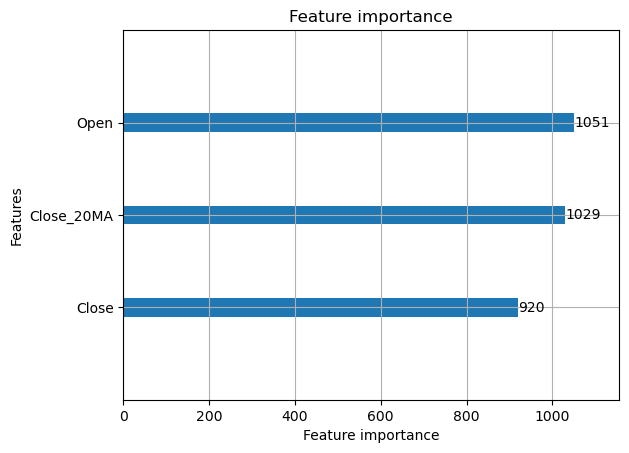

In [22]:
lgb.plot_importance(gbm)

In [23]:
# lgb.create_tree_digraph(gbm, 1)

In [24]:
dtrain = xgb.DMatrix(X_tr, label=y_tr)


In [25]:
param = {'objective': 'binary:logistic'}#, 'num_class': 2}

In [26]:
# 学習
bst = xgb.train(param, dtrain)#, num_round)

In [27]:
dvalid = xgb.DMatrix(X_va)

y_tr_prob_bst = bst.predict(dtrain)
y_tr_pred_bst = np.where(y_tr_prob_bst < 0.5, 0, 1)
y_va_prob_bst = bst.predict(dvalid)
y_va_pred_bst = np.where(y_va_prob_bst < 0.5, 0, 1)

accuracy_tr_bst = accuracy_score(y_tr, y_tr_pred_bst)
accuracy_va_bst = accuracy_score(y_va, y_va_pred_bst)

print("学習データの精度", accuracy_tr_bst)
print("評価データの精度", accuracy_va_bst)

dtest = xgb.DMatrix(X_test)
y_test_prob_bst = bst.predict(dtest)
y_test_pred_bst = np.where(y_test_prob_bst < 0.5, 0, 1)
# print(y_test_pred_bst)


# test_df['Up'] = y_test_pred_bst
# test_df['Up'] = test_df['Up'].astype(int)

# submit_df = test_df[['Date', 'Up']].set_index('Date')
# submit_df.dtypes

# submit_df.to_csv("../data/submission_bst.csv", header=False)

学習データの精度 0.6981481481481482
評価データの精度 0.5295566502463054


bstは後半全部0になっている

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

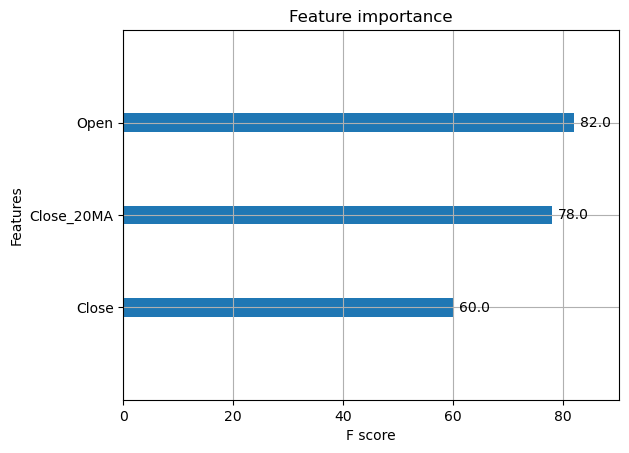

In [28]:
xgb.plot_importance(bst)

In [29]:
nn = MLPClassifier(hidden_layer_sizes=(100, ),
                   activation='relu',
                   solver='adam',
                   early_stopping=True,
                #    verbose=True,
                   random_state=42)

In [30]:
nn.fit(X_tr, y_tr)

MLPClassifier(early_stopping=True, random_state=42)

In [31]:
y_tr_pred_nn = nn.predict(X_tr)
y_va_pred_nn = nn.predict(X_va)

accuracy_tr_nn = accuracy_score(y_tr, y_tr_pred_nn)
accuracy_va_nn = accuracy_score(y_va, y_va_pred_nn)

print("学習データの精度", accuracy_tr_nn)
print("評価データの精度", accuracy_va_nn)

y_test_pred_nn = nn.predict(X_test)

test_df['Up_NN'] = y_test_pred_nn
test_df['Up_NN'] = test_df['Up_NN'].astype(int)

submit_df = test_df[['Date', 'Up_NN']].set_index('Date')
submit_df.dtypes

submit_df.to_csv("../data/submission_NN.csv", header=False)

学習データの精度 0.5148148148148148
評価データの精度 0.5147783251231527


In [32]:
# from sklearn.inspection import permutation_importance
# result = permutation_importance(nn, X_tr, y_tr, random_state=42)

# # 特徴量の重要度をプロット
# columns = ['Open', 'High', 'Close', 'Close_20MA']
# plt.bar(columns, result.importances_mean)
# plt.xlabel('Feature Index')
# plt.ylabel('Permutation Importance')
# plt.show()
# # sorted_importances = result.importances_mean.argsort()
# # plt.bar(result['importances'])